<a href="https://colab.research.google.com/github/AdithyaSam-Ganj/Global-Temperature-Analytics/blob/main/Climate_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

# PLotting
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt

!pip install tqdm
from tqdm import tqdm
import plotly.io as pio
pio.renderers.default = "colab"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
global_temp_country = pd.read_csv('/content/drive/MyDrive/Global_temp_data/GlobalLandTemperaturesByCountry.csv')

1 . Trying to Plot global temperatures by country

In [ ]:
#Let's remove the duplicated countries (in the analysis, we don't consider the presence of
#colonies at this the countries) and countries for which no information about the temperature

global_temp_country_clear = global_temp_country[~global_temp_country['Country'].isin(
    ['Denmark', 'Antarctica', 'France', 'Europe', 'Netherlands',
     'United Kingdom', 'Africa', 'South America'])]

global_temp_country_clear = global_temp_country_clear.replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom'])

#Let's average temperature for each country

countries = np.unique(global_temp_country_clear['Country'])
mean_temp = []
for country in countries:
    mean_temp.append(global_temp_country_clear[global_temp_country_clear['Country'] ==
                                               country]['AverageTemperature'].mean())


data = [ dict(
        type = 'choropleth',
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '',
            title = '# Average\nTemperature,\n°C')
            )
       ]


layout = dict(
    title = 'Average land temperature in countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap')

In [ ]:
mean_temp_bar, countries_bar = (list(x) for x in zip(*sorted(zip(mean_temp, countries),
                                                             reverse = True)))
sns.set(font_scale=0.9)
f, ax = plt.subplots(figsize=(4.5, 50))
colors_cw = sns.color_palette('coolwarm', len(countries))
sns.barplot(mean_temp_bar, countries_bar)#, palette = colors_cw[::-1])
Text = ax.set(xlabel='Average temperature', title='Average land temperature in countries')

In [ ]:
global_temp = pd.read_csv("/content/drive/MyDrive/Global_temp_data/GlobalTemperatures.csv")

#Extract the year from a date
years = np.unique(global_temp['dt'].apply(lambda x: x[:4]))
mean_temp_world = []
mean_temp_world_uncertainty = []

for year in years:
    mean_temp_world.append(global_temp[global_temp['dt'].apply(
        lambda x: x[:4]) == year]['LandAverageTemperature'].mean())
    mean_temp_world_uncertainty.append(global_temp[global_temp['dt'].apply(
                lambda x: x[:4]) == year]['LandAverageTemperatureUncertainty'].mean())

trace0 = go.Scatter(
    x = years,
    y = np.array(mean_temp_world) + np.array(mean_temp_world_uncertainty),
    fill= None,
    mode='lines',
    name='Uncertainty top',
    line=dict(
        color='rgb(0, 255, 255)',
    )
)
trace1 = go.Scatter(
    x = years,
    y = np.array(mean_temp_world) - np.array(mean_temp_world_uncertainty),
    fill='tonexty',
    mode='lines',
    name='Uncertainty bot',
    line=dict(
        color='rgb(0, 255, 255)',
    )
)

trace2 = go.Scatter(
    x = years,
    y = mean_temp_world,
    name='Average Temperature',
    line=dict(
        color='rgb(199, 121, 093)',
    )
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in world',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
#Extract the year from a date
years = np.unique(global_temp_country_clear['dt'].apply(lambda x: x[:4]))

#Let's create an array and add the values of average temperatures in the countries every 10 years
mean_temp_year_country = [ [0] * len(countries) for i in range(len(years[::10]))]

j = 0
for country in countries:
    all_temp_country = global_temp_country_clear[global_temp_country_clear['Country'] == country]
    i = 0
    for year in years[::10]:
        mean_temp_year_country[i][j] = all_temp_country[all_temp_country['dt'].apply(
                lambda x: x[:4]) == year]['AverageTemperature'].mean()
        i +=1
    j += 1


#Let's create a Streaming in Plotly (here, alas, does not work, so commented out)
#stream_tokens = tls.get_credentials_file()['stream_ids']
#token =  stream_tokens[-1]
#stream_id = dict(token=token, maxpoints=60)

data = [ dict(
        type = 'choropleth',
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '',
            title = '# Average\nTemperature,\n°C'),
        #The following line is also needed to create Stream
        #stream = stream_id
            )
       ]

layout = dict(
    title = 'Average land temperature in countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        type = 'equirectangular'
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='world_temp_map')

# Analysing Bangalore's temperature with SAMARIMA models


In [ ]:
# Reading and transforming the file
cities = pd.read_csv('/content/drive/MyDrive/Global_temp_data/GlobalLandTemperaturesByCity.csv')
bangalore = cities.loc[cities['City'] == 'Bangalore', ['dt','AverageTemperature']]
bangalore.columns = ['Date','Temp']
bangalore['Date'] = pd.to_datetime(bangalore['Date'])
bangalore.reset_index(drop=True, inplace=True)
bangalore.set_index('Date', inplace=True)

#I'm going to consider the temperature just from 1900 until the end of 2012
bangalore = bangalore.loc['1900':'2013-01-01']
bangalore = bangalore.asfreq('M', method='bfill')
bangalore.head()

,Temp
Date,
1900-01-31,25.707
1900-02-28,27.876
1900-03-31,28.352
1900-04-30,28.367
1900-05-31,25.948


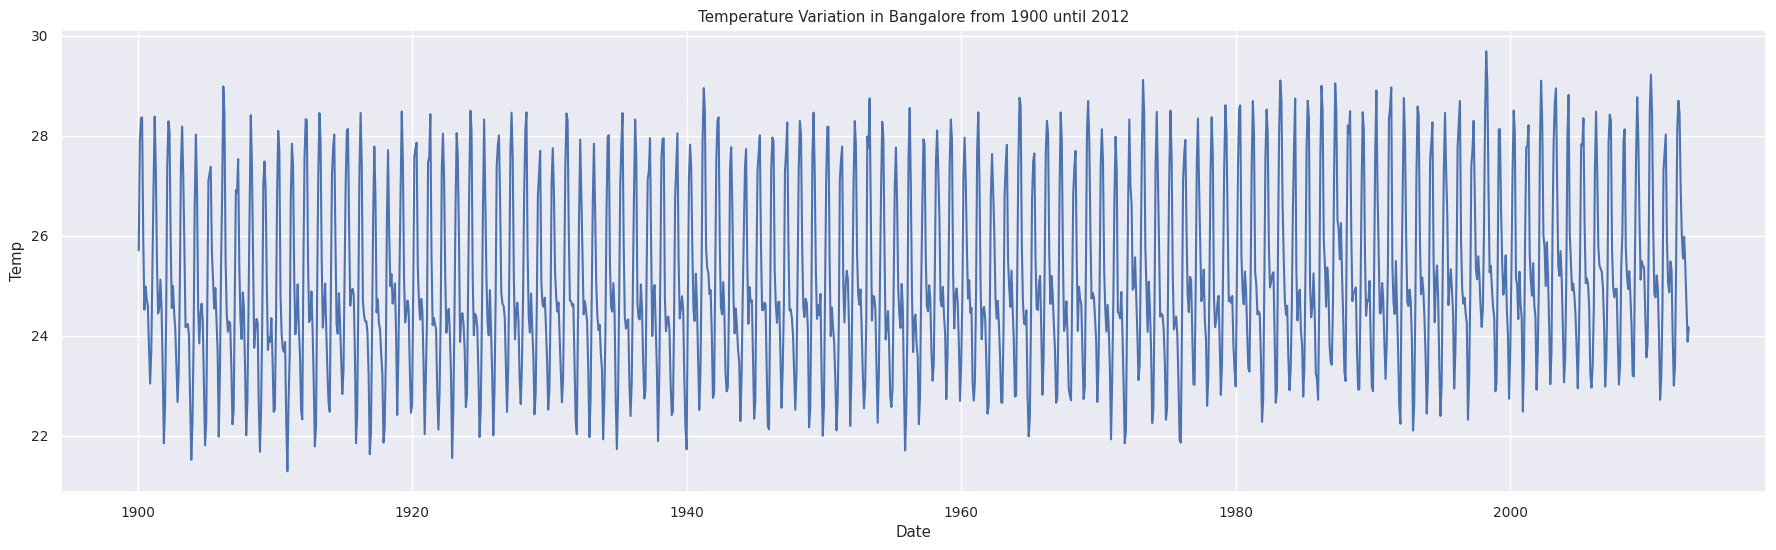

In [ ]:
plt.figure(figsize=(22,6))
sns.lineplot(x=bangalore.index, y=bangalore['Temp'])
plt.title('Temperature Variation in Bangalore from 1900 until 2012')
plt.show()

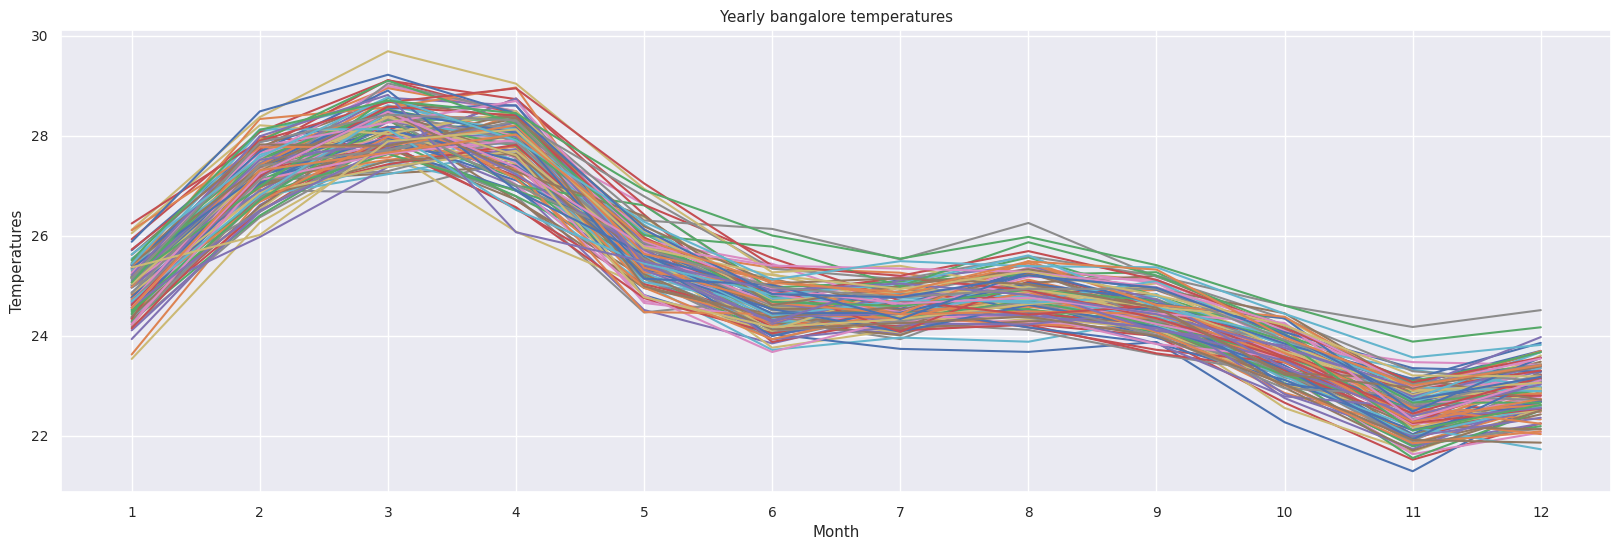

In [ ]:
# i'm going to create a pivot table to plot the monthly temperatures through the years
bangalore['month'] = bangalore.index.month
bangalore['year'] = bangalore.index.year
pivot = pd.pivot_table(bangalore, values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Yearly bangalore temperatures')
plt.xlabel('Month')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

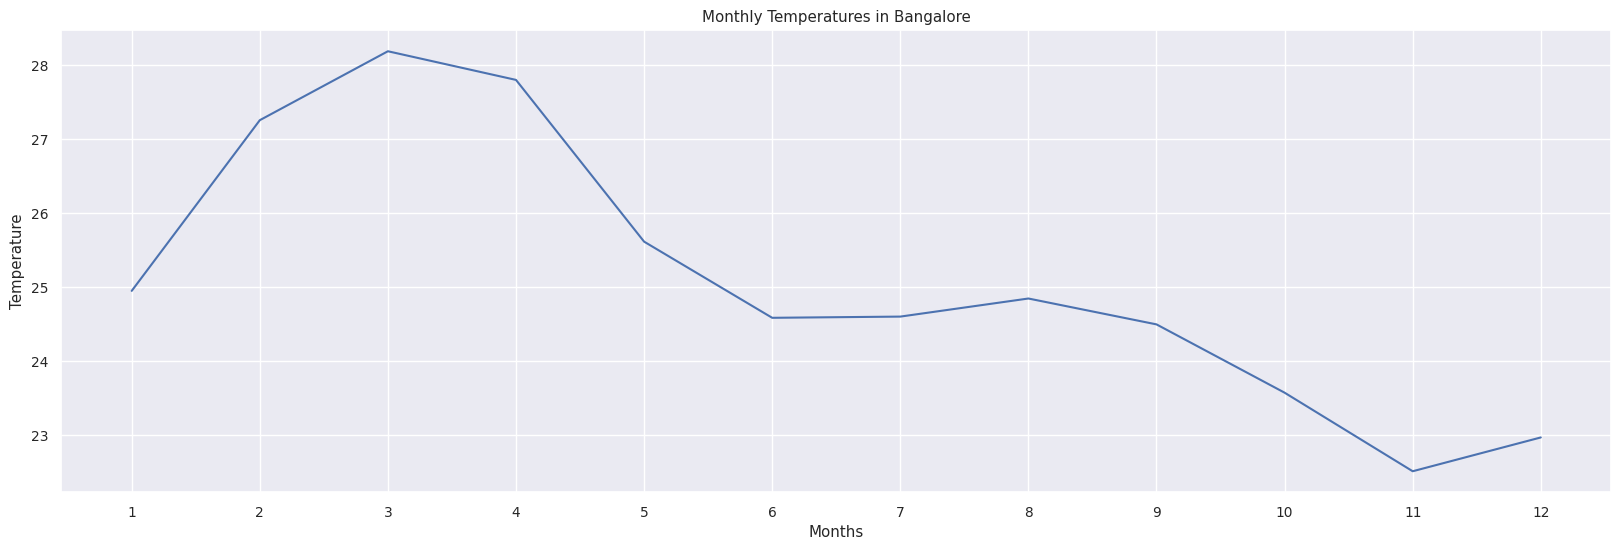

In [ ]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly Temperatures in Bangalore')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

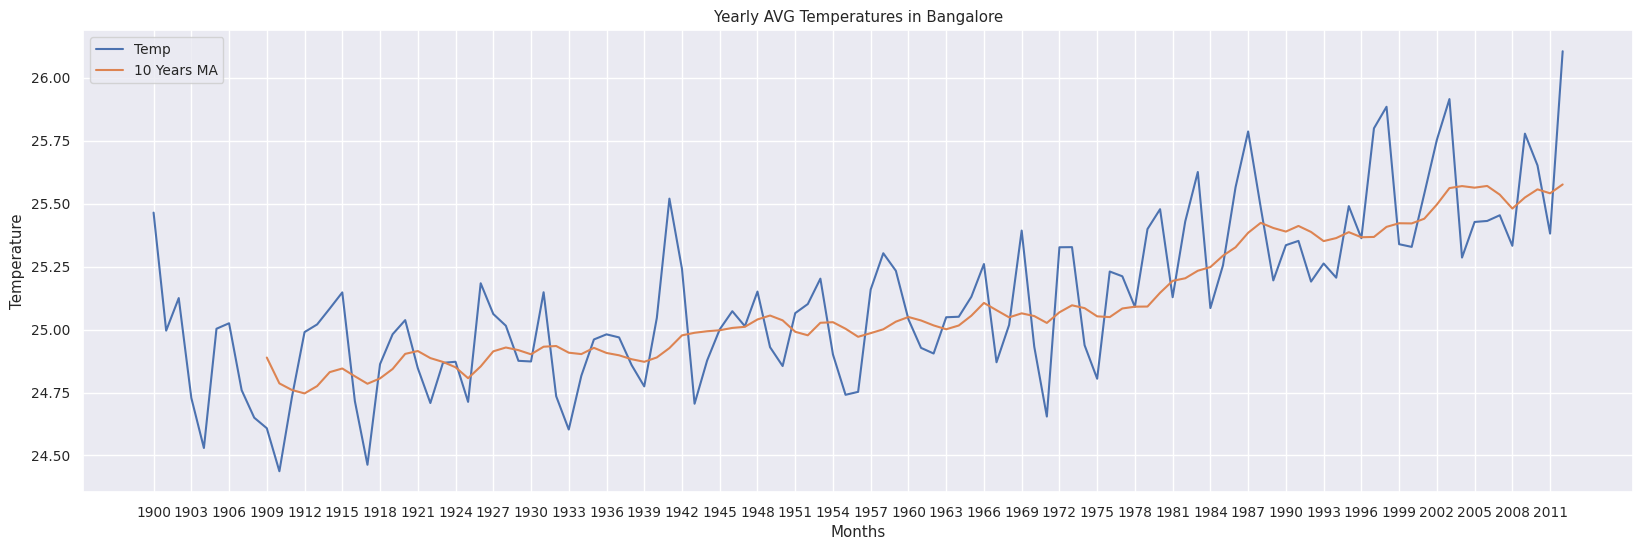

In [ ]:
year_avg = pd.pivot_table(bangalore, values='Temp', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['Temp'].rolling(10).mean()
year_avg[['Temp','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly AVG Temperatures in Bangalore')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1900,2012,3)])
plt.show()

In [ ]:
train = bangalore[:-60].copy()
val = bangalore[-60:-12].copy()
test = bangalore[-12:].copy()


# Excluding the first line, as it has NaN values
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()


def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values
rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 1.2201 celsius degrees


In [ ]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"

    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Bangalore Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()

    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)

    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)

    print(adftest)

    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")


Results of Dickey-Fuller Test:
Test Statistic                   -3.1537
p-value                           0.0228
Lags Used                        23.0000
Number of Observations Used    1272.0000
Critical Value (1%)              -3.4355
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


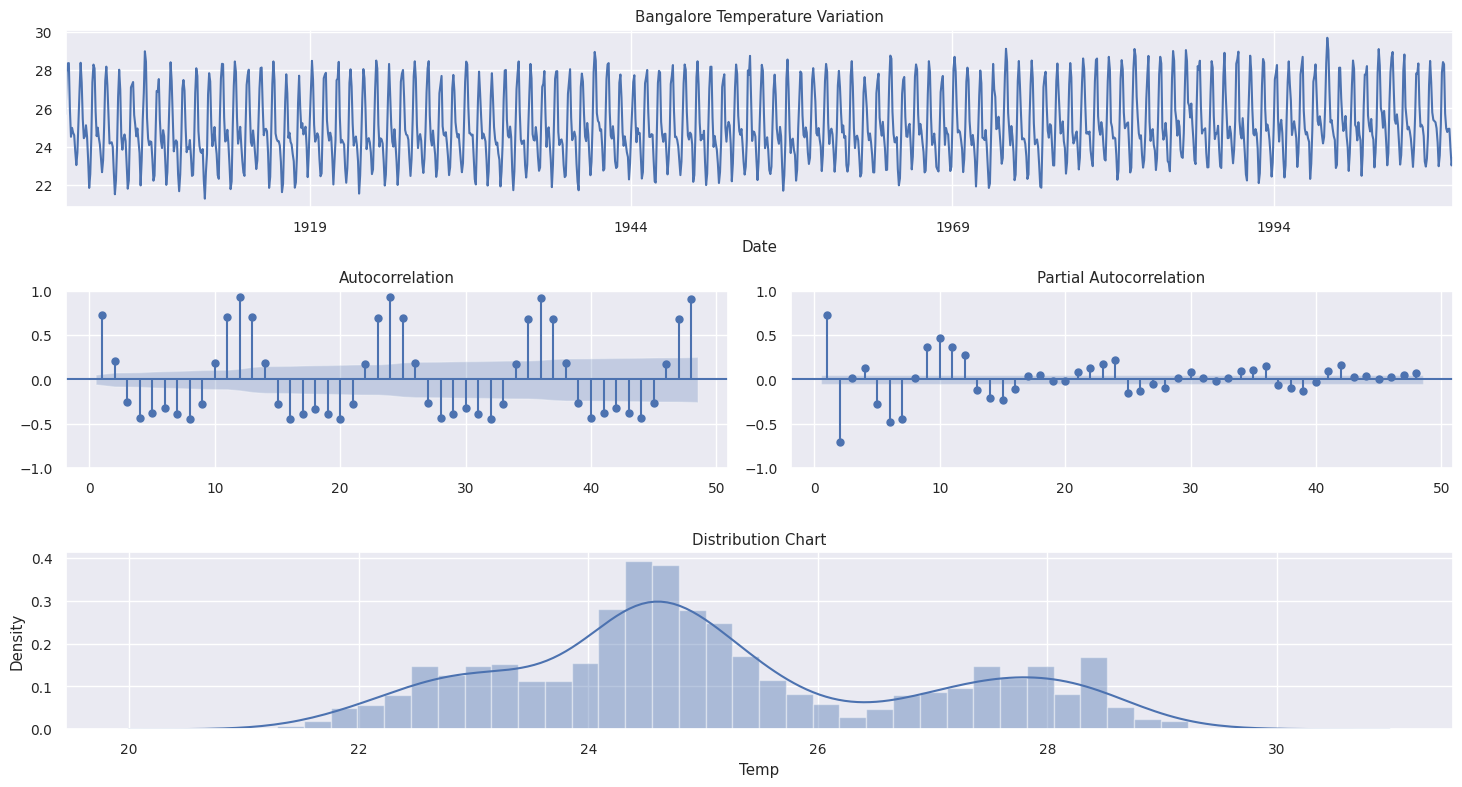

In [ ]:
# The first approach is to check the series without any transformation
check_stationarity(train['Temp'])

The series has an interesting behavior, there is a sequential significative negative autocorrelation starting at lag 6 and repeating each 12 months, it's because of the difference in the seasons, if today is winter with cold temperatures in 6 months we will have higher temperatures in the summer, that's why the negative autocorrelation occurs. These temperatures usually walk in opposite directions.

Also, from lag 12 and sequentially from every 12 lags there is a significant positive autocorrelation. The PACF shows a positive spike in the first lag and a drop to negative PACF in the following lags.

This behavior between the ACF and PACF plots suggests an AR(1) model and also a first seasonal difference ( Yt−Yt−12 ). I'll plot the stationarity function again with the first seasonal difference to see if we will need some SAR(P) or SMA(Q) parameter:

Results of Dickey-Fuller Test:
Test Statistic                  -12.8791
p-value                           0.0000
Lags Used                        23.0000
Number of Observations Used    1260.0000
Critical Value (1%)              -3.4356
Critical Value (5%)              -2.8638
Critical Value (10%)             -2.5680
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


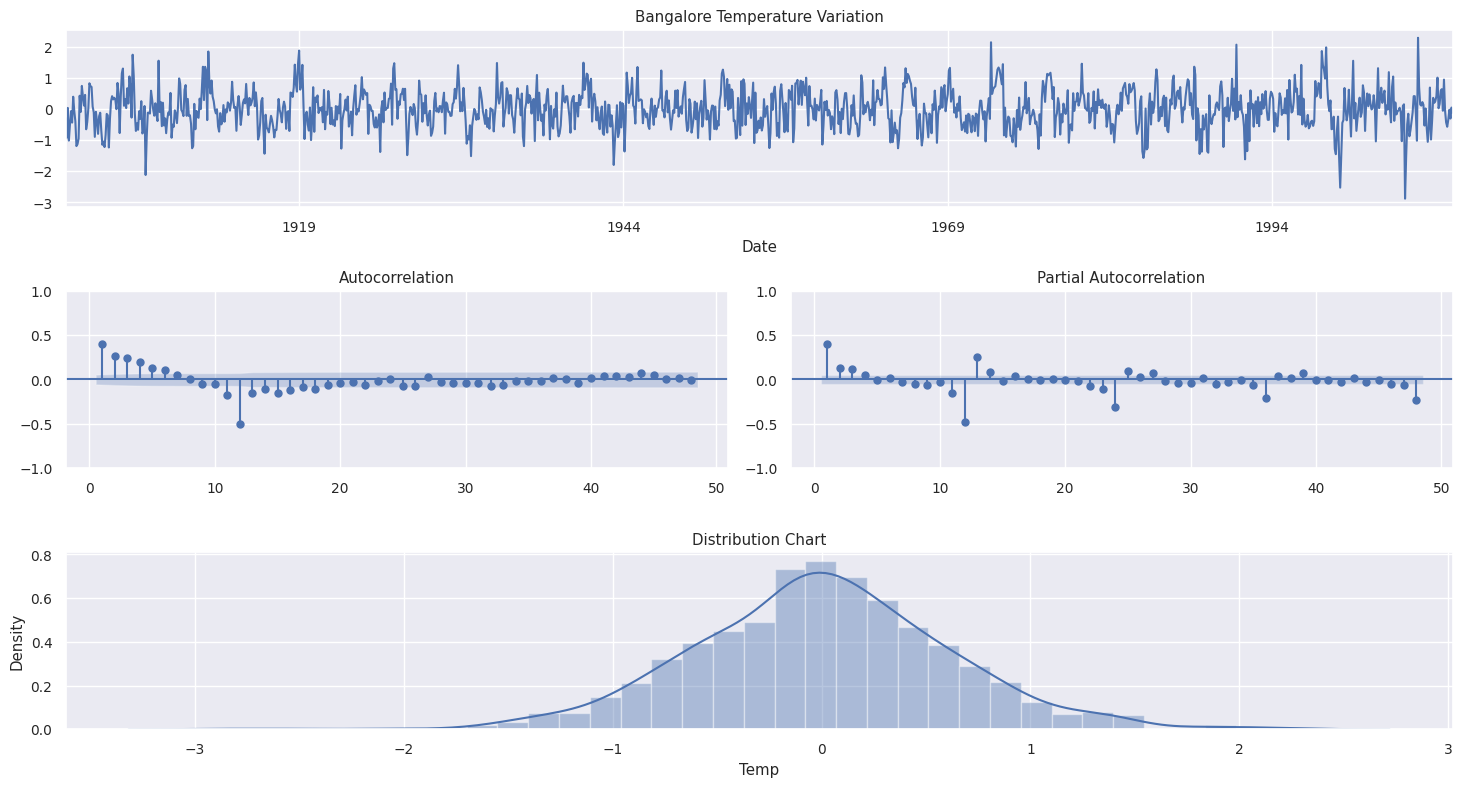

In [ ]:
check_stationarity(train['Temp'].diff(12).dropna())


In [ ]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()

    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])

    return prediction


In [ ]:
# Let's test it in the validation set
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((3,0,0),(0,1,1,12),'c'))

In [ ]:
val

In [ ]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was 0.3681 celsius degrees
It's a decrease of -69.83% in the RMSE


In [ ]:
# Creating the error column
val['Error'] = val['Temp'] - val['Pred']

In [ ]:
val.columns

Index(['Temp', 'year', 'month', 'Pred', 'Error'], dtype='object')

In [ ]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))

    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')

    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')

    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)

    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [ ]:
# We need to remove some columns to plot the charts
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,Temp,Pred,Error
Date,,,
2008-01-31,25.365,25.357378,0.007622
2008-02-29,26.015,27.668859,-1.653859
2008-03-31,27.884,28.035666,-0.151666
2008-04-30,28.126,27.710097,0.415903
2008-05-31,25.764,25.655331,0.108669


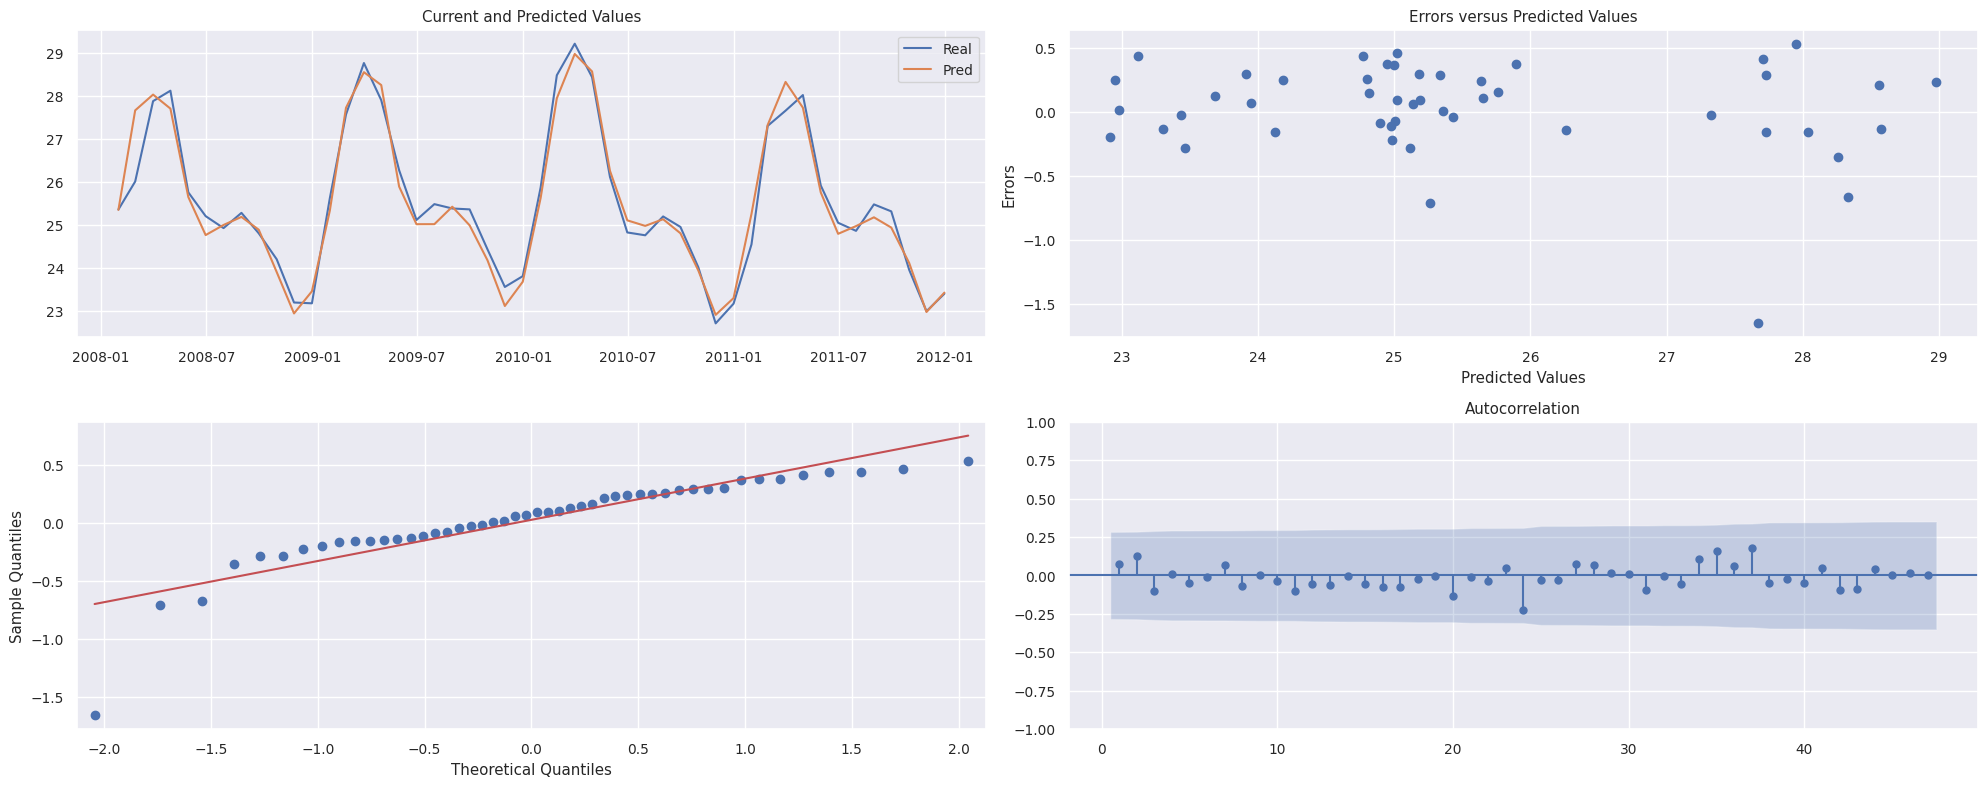

In [ ]:
plot_error(val)


In [ ]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))

    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')

    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')

    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)

    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [ ]:
#Creating the new concatenating the training and validation set:
future = pd.concat([train['Temp'], val['Temp']])
future.head()


Date
1900-01-31    25.707
1900-02-28    27.876
1900-03-31    28.352
1900-04-30    28.367
1900-05-31    25.948
Freq: M, Name: Temp, dtype: float64

In [ ]:
# Using the same parameters of the fitted model
model = sm.tsa.statespace.SARIMAX(future, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

In [ ]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+100))

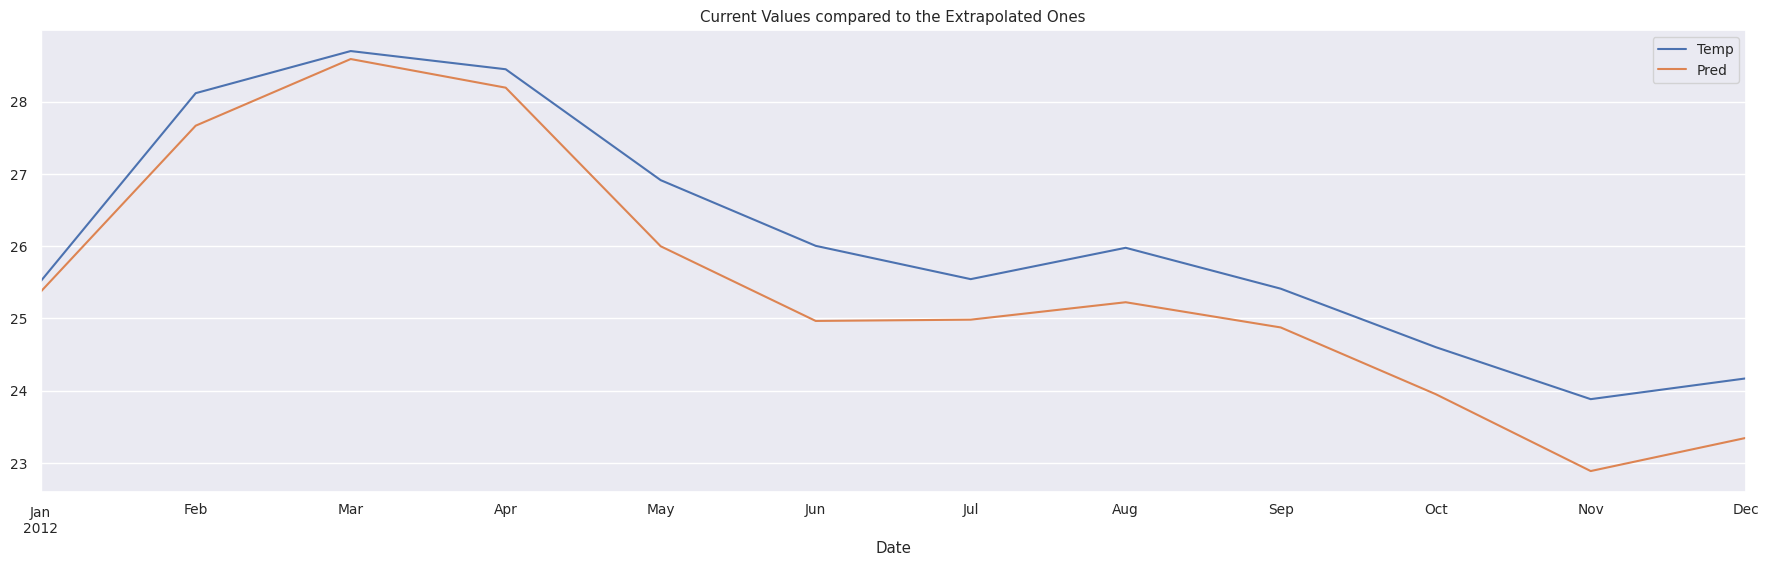

In [ ]:
test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()

In [ ]:
test_baseline = test['Temp'].shift()

test_baseline[0] = test['Temp'][0]

rmse_test_base = measure_rmse(test['Temp'],test_baseline)
rmse_test_extrap = measure_rmse(test['Temp'], test['Pred'])

print(f'The baseline RMSE for the test baseline was {round(rmse_test_base,2)} celsius degrees')
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap,2)} celsius degrees')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')


The baseline RMSE for the test baseline was 1.01 celsius degrees
The baseline RMSE for the test extrapolation was 0.68 celsius degrees
That is an improvement of 33.35%


In [ ]:
print('hi')

hi
